In [1]:
#!pip install transformers requests beautifulsoup4 seaborn nltk tqdm

In [2]:
#!pip install matplotlib plotly pandas sickit-learn gensim 

In [3]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [57]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
from tqdm.auto import tqdm 


from nltk.corpus import stopwords 
import re 
from collections import Counter
from string import punctuation
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.metrics import confusion_matrix

from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lb = LabelEncoder()

In [5]:
df = pd.read_csv('twitter_training.csv')

In [6]:
df = df.drop_duplicates(subset=['im getting on borderlands and i will murder you all ,'])

In [7]:
df= df.rename(columns={"Borderlands":"Feature2","im getting on borderlands and i will murder you all ,":"Feature1","Positive": "labels"})

In [8]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)


In [9]:
df['tweet_len'] = [len(text.split()) for text in df.tweets]

In [10]:
df = df[~(df['tweet_len'] < 5) & ~(df['tweet_len'] > 60)]

In [11]:
# Assuming 'labels' is the column name in your DataFrame
df = df[df['labels'] != 'Irrelevant']

In [12]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [13]:
# Preprocessing the tweets
def preprocess_tweet(tweet):

    # Removing the mentions
    tweet = re.sub(r'@[\w]+', '', tweet)

    # Removing hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    
    # Removing URLs
    tweet = re.sub(r'https?://\S+', '', tweet)
    
    # Remove non-alphabetic characters
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweet)

    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]

    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

df['Cleaned_Tweet'] = df['tweets'].apply(preprocess_tweet)

In [14]:
# Initialize LabelEncoder
lb = LabelEncoder()

# Fit and transform labels
df['labels'] = lb.fit_transform(df['labels'].values)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53286 entries, 0 to 74680
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   2401           53286 non-null  int64 
 1   labels         53286 non-null  int32 
 2   tweets         53286 non-null  object
 3   tweet_len      53286 non-null  int64 
 4   Cleaned_Tweet  53286 non-null  object
dtypes: int32(1), int64(2), object(2)
memory usage: 2.2+ MB


In [16]:
df['labels'].unique()

array([2, 1, 0])

In [17]:

tweets = df['Cleaned_Tweet'].values
labels = df['labels'].values

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(tweets)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Converting labels to one-hot encoding or use LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = pd.get_dummies(labels_encoded).values

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels_onehot, test_size=0.2, random_state=42, stratify=labels
)


In [18]:
# BiLSTM model architecture
embedding_dim = 100

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)
bidirectional_layer_1 = Bidirectional(LSTM(100, return_sequences=True))(embedding_layer)
dropout_layer_1 = Dropout(0.5)(bidirectional_layer_1)
bidirectional_layer_2 = Bidirectional(LSTM(100, return_sequences=True))(dropout_layer_1)
dropout_layer_2 = Dropout(0.5)(bidirectional_layer_2)
bidirectional_layer_3 = Bidirectional(LSTM(100))(dropout_layer_2)
dropout_layer_3 = Dropout(0.5)(bidirectional_layer_3)
output_layer = Dense(3, activation='softmax')(dropout_layer_3)  

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(lr=0.0001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Defining EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5, 
    restore_best_weights=True,  
)

# Training the model with EarlyStopping callback
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],  
)

Epoch 1/50



2132/2132 [==============================] - 128s 57ms/step - loss: 0.6595 - accuracy: 0.7278 - val_loss: 0.4393 - val_accuracy: 0.8373
Epoch 2/50
2132/2132 [==============================] - 120s 56ms/step - loss: 0.2763 - accuracy: 0.9078 - val_loss: 0.3541 - val_accuracy: 0.8739
Epoch 3/50
2132/2132 [==============================] - 116s 55ms/step - loss: 0.1589 - accuracy: 0.9472 - val_loss: 0.3211 - val_accuracy: 0.8928
Epoch 4/50
2132/2132 [==============================] - 116s 54ms/step - loss: 0.1038 - accuracy: 0.9670 - val_loss: 0.3571 - val_accuracy: 0.8992
Epoch 5/50
2132/2132 [==============================] - 117s 55ms/step - loss: 0.0767 - accuracy: 0.9743 - val_loss: 0.3701 - val_accuracy: 0.8924
Epoch 6/50
2132/2132 [==============================] - 118s 55ms/step - loss: 0.0595 - accuracy: 0.9789 - val_loss: 0.3757 - val_accuracy: 0.9015
Epoch 7/50
2132/2132 [==============================] - 116s 54ms/step - loss: 0.0443 - accuracy: 0.9849 - val_loss: 0.4233 - val

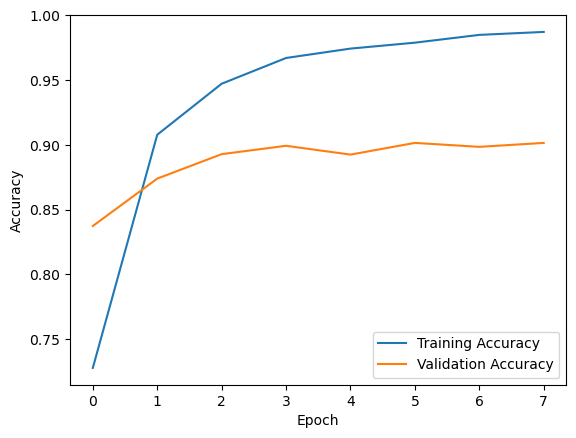

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# Assuming your model is already trained and you have predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions back to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test_labels, y_pred_labels)

print("Classification Report:\n", report)

334/334 [==============================] - 8s 19ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      3936
           1       0.90      0.85      0.88      3240
           2       0.86      0.91      0.89      3482

    accuracy                           0.89     10658
   macro avg       0.89      0.89      0.89     10658
weighted avg       0.89      0.89      0.89     10658



In [22]:
# Loading the new data into a DataFrame
new_data = pd.read_excel('output_file_sentiments.xlsx')  

new_data = new_data.dropna(subset=['Cleaned_Tweet'])

# Extracting the tweets
new_tweets = new_data['Cleaned_Tweet'].astype(str).values



In [23]:
# Tokenizing and adding a pad sequences for the new data 
new_sequences = tokenizer.texts_to_sequences(new_tweets)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')

# Performing the predictions using the trained model
new_predictions = model.predict(new_padded_sequences)

# Converting the predictions to labels
new_predicted_labels = np.argmax(new_predictions, axis=1)

# Map labels back to original sentiment classes using label_encoder
new_predicted_sentiments = label_encoder.inverse_transform(new_predicted_labels)

# Creating a new column in the new_data DataFrame with the predicted sentiments
new_data['Predicted_Sentiment'] = new_predicted_sentiments


103/103 [==============================] - 2s 18ms/step


In [24]:
# Mapping labels to the desired format
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Converting the predictions of the new model to the desired format
new_predicted_sentiments_mapped = [sentiment_mapping[label] for label in new_predicted_labels]

# Creating a new column in the new_data DataFrame with the mapped predicted sentiments
new_data['Predicted_Sentiment_Mapped'] = new_predicted_sentiments_mapped

In [31]:
new_data

,User,UTC Date,Tweet,Cleaned_Tweet,Negative,Neutral,Positive,Sentiment,Year,Month,Predicted_Sentiment,Predicted_Sentiment_Mapped
0,JCPinHumber/NthYorks,2023-11-08 14:01:00,Procurement Assistant @HumbersideFire in Hull\...,procurement assistant hull see,0.201464,0.729944,0.068592,Neutral,2023,November,1,Neutral
1,Kristian Gilmore,2023-11-07 23:01:06,@HallMohame77536 @Sinan05073661 @elquimeras @R...,get launch profile,0.090509,0.796979,0.112513,Neutral,2023,November,2,Positive
2,Beth,2023-11-07 20:18:02,"What an achievement for Our Rookie Mary, she h...",achievement rookie mary done amazingly persona...,0.001917,0.037708,0.960376,Positive,2023,November,1,Neutral
3,Delta Strand,2023-11-06 23:52:56,We are so excited that our firework night is f...,excited firework night finally,0.001157,0.016633,0.982210,Positive,2023,November,2,Positive
4,Vicky Shakesby MBE,2023-11-06 20:05:44,Presented CM Walker his 30 year long service c...,presented cm walker year long service clasp ev...,0.004754,0.239910,0.755336,Positive,2023,November,2,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
3284,Tony Clark QFSM,2019-11-10 13:44:52,Fantastic turnout #RemembranceSunday at Howden...,fantastic turnout howden,0.021842,0.232031,0.746126,Positive,2019,November,2,Positive
3285,HFR Solutions CIC,2019-11-10 09:45:06,"On Remembrance Sunday, we are extremely proud ...",remembrance sunday extremely proud sponsored w...,0.001497,0.024751,0.973752,Positive,2019,November,2,Positive
3286,Lyndsay Howden,2019-11-10 09:01:56,Proud to represent @HumbersideFire at the Clee...,proud represent cleethorpes rememberance event...,0.003184,0.059507,0.937308,Positive,2019,November,2,Positive
3287,Lesley Tidder,2019-11-09 21:46:38,"@HumbersideFire I work at a homeless hostel, r...",work homeless hostel resident heard gentleman ...,0.034116,0.380350,0.585534,Positive,2019,November,0,Negative


In [26]:
new_data['Predicted_Sentiment'].value_counts()

Predicted_Sentiment
2    1803
1     781
0     699
Name: count, dtype: int64

In [27]:
# Extract unique labels from the actual sentiments and predicted sentiments
actual_labels = sorted(new_data['Sentiment'].unique())
predicted_labels = sorted(new_data['Predicted_Sentiment_Mapped'].unique())

# Print unique labels
print("Actual Labels:", actual_labels)
print("Predicted Labels:", predicted_labels)


Actual Labels: ['negative', 'neutral', 'positive']
Predicted Labels: ['Negative', 'Neutral', 'Positive']


In [28]:
# Convert actual labels to title case to match predicted labels
new_data['Sentiment'] = new_data['Sentiment'].apply(lambda x: x.title())

# Extract unique labels from the actual sentiments and predicted sentiments
actual_labels = sorted(new_data['Sentiment'].unique())
predicted_labels = sorted(new_data['Predicted_Sentiment_Mapped'].unique())

# Print unique labels
print("Actual Labels:", actual_labels)
print("Predicted Labels:", predicted_labels)


Actual Labels: ['Negative', 'Neutral', 'Positive']
Predicted Labels: ['Negative', 'Neutral', 'Positive']


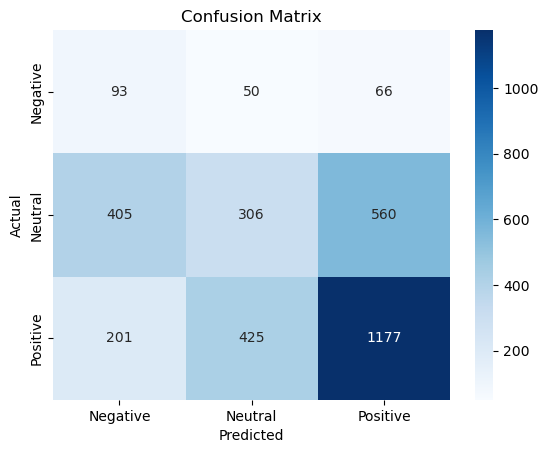

In [29]:
# Confusion matrix
conf_matrix = confusion_matrix(new_data['Sentiment'], new_data['Predicted_Sentiment_Mapped'], labels=actual_labels)

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actual_labels, yticklabels=actual_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

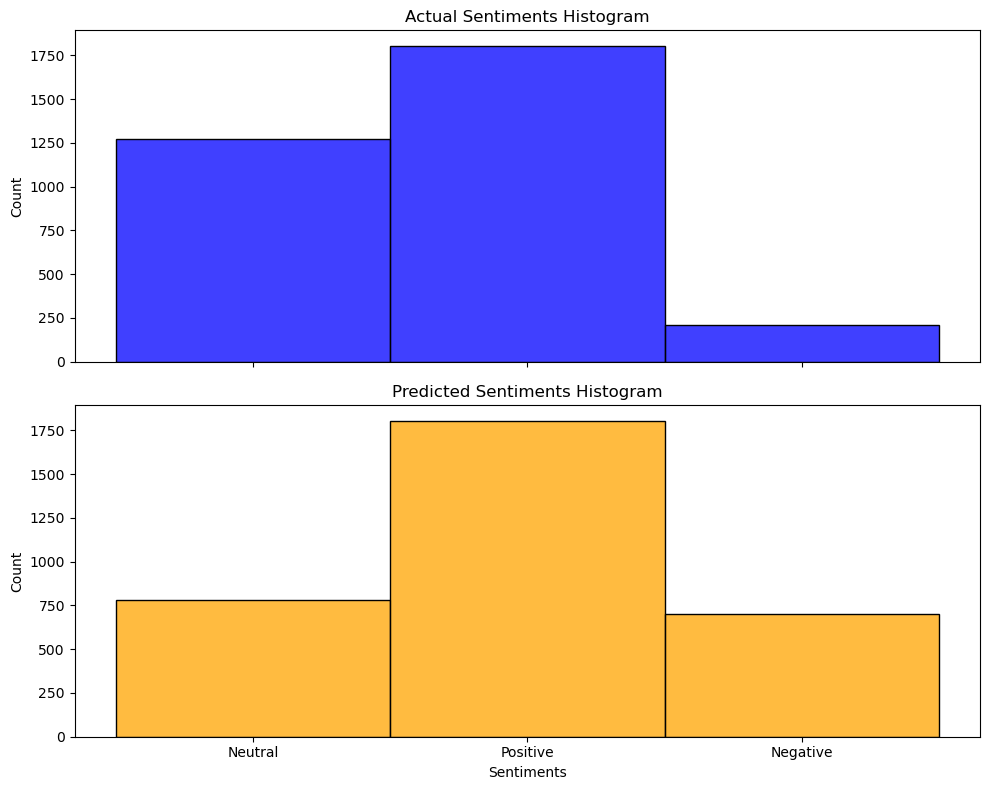

In [30]:
# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

# Plot the histogram for actual sentiments
sns.histplot(new_data['Sentiment'], bins=3, kde=False, color='blue', ax=ax1)
ax1.set_title('Actual Sentiments Histogram')

# Plot the histogram for predicted sentiments
sns.histplot(new_data['Predicted_Sentiment_Mapped'], bins=3, kde=False, color='orange', ax=ax2)
ax2.set_title('Predicted Sentiments Histogram')

plt.xlabel('Sentiments')

plt.tight_layout()
plt.show()

In [ ]:
mismatched_samples = new_data[new_data['Sentiment'] != new_data['Predicted_Sentiment_Mapped']]

# Print out a sample of the mismatched tweets
for index, row in mismatched_samples.sample(30).iterrows():
    print(f"Tweet: {row['Tweet']}")
    print(f"Actual Sentiment: {row['Sentiment']}, Predicted Sentiment: {row['Predicted_Sentiment_Mapped']}")
    print('-' * 50)


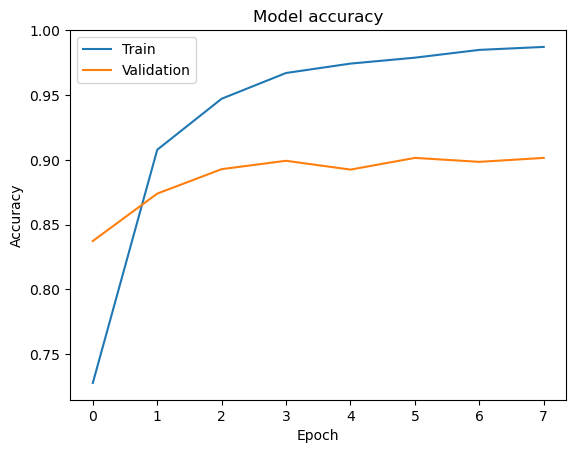

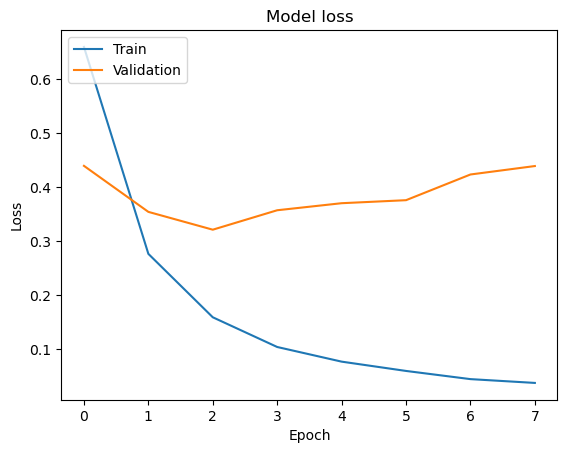

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


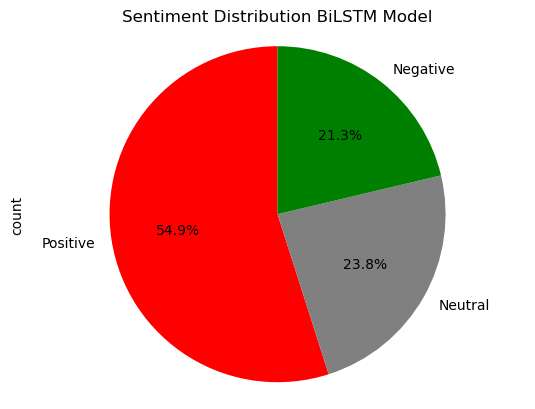

In [34]:
sentiment_counts = new_data['Predicted_Sentiment_Mapped'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'green'])
plt.title('Sentiment Distribution BiLSTM Model')
plt.axis('equal')  

plt.savefig('Sentiment Distribution BiLSTM Model.png')
plt.show()


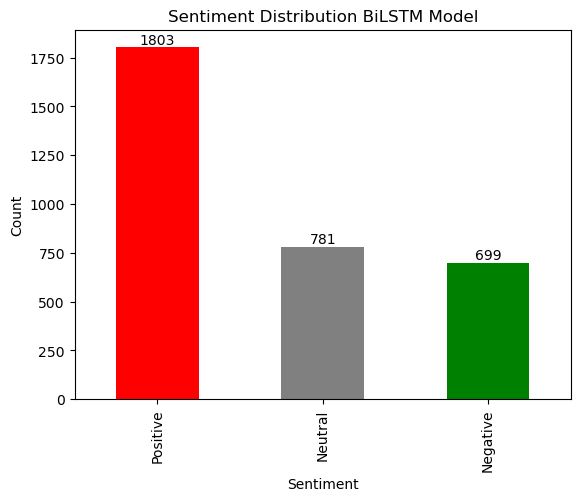

In [36]:
sentiment_counts = new_data['Predicted_Sentiment_Mapped'].value_counts()
sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution BiLSTM Model')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Optionally, you can annotate the bars with their respective counts
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.savefig('Sentiment Distribution BiLSTM Model.png')
plt.show()

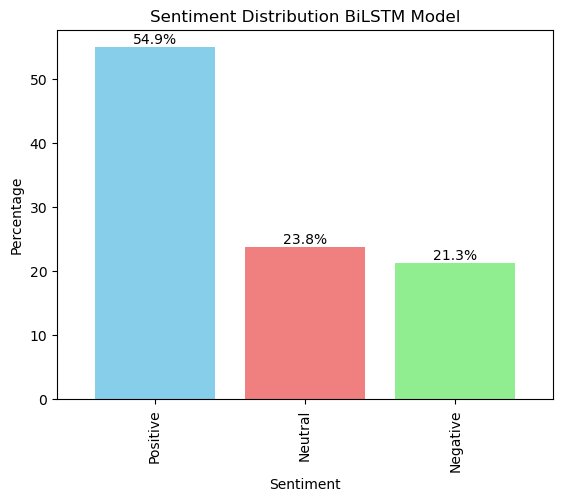

In [42]:
sentiment_counts = new_data['Predicted_Sentiment_Mapped'].value_counts(normalize=True) * 100
colors = ['skyblue', 'lightcoral', 'lightgreen']

sentiment_counts.plot(kind='bar', color=colors, width=0.8)
plt.title('Sentiment Distribution BiLSTM Model')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')

# Optionally, you can annotate the bars with their respective percentages
for i, percent in enumerate(sentiment_counts):
    plt.text(i, percent + 0.1, f'{percent:.1f}%', ha='center', va='bottom')

plt.savefig('Sentiment Distribution BiLSTM Model.png')
plt.show()

# XLNET Model for Risk Detection

In [43]:
# Loading the Excel file
df = pd.read_excel('negative_sentiments.xlsx')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   User           209 non-null    object 
 1   Tweet          209 non-null    object 
 2   Cleaned_Tweet  209 non-null    object 
 3   Negative       209 non-null    float64
 4   Neutral        209 non-null    float64
 5   Positive       209 non-null    float64
 6   Sentiment      209 non-null    object 
 7   Label          151 non-null    float64
dtypes: float64(4), object(4)
memory usage: 13.2+ KB


In [45]:
# Separating labeled and unlabeled data
predict_df = df[df['Label'].isna()]
train_df = df.dropna(subset=['Label'])

In [46]:
# Tokenizing and prepare data for training
tokenizer_new = Tokenizer()
tokenizer_new.fit_on_texts(train_df['Cleaned_Tweet'])
vocab_size_new = len(tokenizer_new.word_index) + 1

In [47]:
# Tokenizing unigrams
X_unigrams_new = tokenizer_new.texts_to_sequences(train_df['Cleaned_Tweet'])
X_unigrams_new = pad_sequences(X_unigrams_new, padding='post', truncating='post', maxlen=128)

In [48]:
# Creating bigrams 
X_bigrams_new = []
for tweet_tokens in zip(train_df['Cleaned_Tweet'].str.split(), train_df['Cleaned_Tweet'].str.split().shift(-1)):
    bigram_sequence = tokenizer_new.texts_to_sequences([' '.join(map(str, tweet_tokens))])
    X_bigrams_new.extend(bigram_sequence)

X_bigrams_new = pad_sequences(X_bigrams_new, padding='post', truncating='post', maxlen=128)

In [50]:
# Creating trigrams
X_trigrams_new = []
for tweet_tokens in zip(train_df['Cleaned_Tweet'].str.split(), train_df['Cleaned_Tweet'].str.split().shift(-1), train_df['Cleaned_Tweet'].str.split().shift(-2)):
    trigram_sequence = tokenizer_new.texts_to_sequences([' '.join(map(str, tweet_tokens))])
    X_trigrams_new.extend(trigram_sequence)

X_trigrams_new = pad_sequences(X_trigrams_new, padding='post', truncating='post', maxlen=128)

In [51]:
# Concatenating unigrams, bigrams, and trigrams
X_combined_new = np.concatenate([X_unigrams_new, X_bigrams_new, X_trigrams_new], axis=1)

y_new = train_df['Label'].values

In [52]:
# Splitting the training data into train and validation sets
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_combined_new, y_new, test_size=0.1, random_state=42)

In [53]:
# Defining the BiLSTM model with three layers and dropout
embedding_dim_new = 50

inputs_new = Input(shape=(384,))  
embedding_layer_new = Embedding(input_dim=vocab_size_new, output_dim=embedding_dim_new, input_length=384)(inputs_new)
bi_lstm_1_new = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer_new)
dropout_1_new = Dropout(0.5)(bi_lstm_1_new)
bi_lstm_2_new = Bidirectional(LSTM(64, return_sequences=True))(dropout_1_new)
dropout_2_new = Dropout(0.5)(bi_lstm_2_new)
bi_lstm_3_new = Bidirectional(LSTM(64))(dropout_2_new)
dropout_final_new = Dropout(0.5)(bi_lstm_3_new)
outputs_new = Dense(1, activation='sigmoid')(dropout_final_new)


In [54]:
# Compiling the model
model_new = Model(inputs=inputs_new, outputs=outputs_new)
model_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the BiLSTM model with early stopping
epochs_new = 25
batch_size_new = 8

history_new = model_new.fit(
    X_train_new, y_train_new,
    epochs=epochs_new,
    batch_size=batch_size_new,
    validation_data=(X_val_new, y_val_new)
)


Epoch 1/25
17/17 [==============================] - 15s 297ms/step - loss: 0.6021 - accuracy: 0.7704 - val_loss: 0.2220 - val_accuracy: 0.9375
Epoch 2/25
17/17 [==============================] - 3s 195ms/step - loss: 0.5683 - accuracy: 0.7630 - val_loss: 0.4094 - val_accuracy: 0.9375
Epoch 3/25
17/17 [==============================] - 3s 198ms/step - loss: 0.5225 - accuracy: 0.7630 - val_loss: 0.2658 - val_accuracy: 0.9375
Epoch 4/25
17/17 [==============================] - 3s 199ms/step - loss: 0.4455 - accuracy: 0.7852 - val_loss: 0.2516 - val_accuracy: 0.9375
Epoch 5/25
17/17 [==============================] - 3s 204ms/step - loss: 0.2095 - accuracy: 0.9481 - val_loss: 0.7196 - val_accuracy: 0.8125
Epoch 6/25
17/17 [==============================] - 3s 199ms/step - loss: 0.1469 - accuracy: 0.9704 - val_loss: 0.5164 - val_accuracy: 0.8750
Epoch 7/25
17/17 [==============================] - 3s 200ms/step - loss: 0.0452 - accuracy: 0.9926 - val_loss: 0.3590 - val_accuracy: 0.9375
Epoch

In [55]:
# Validation for the new model and data
val_preds_new = model_new.predict(X_val_new).flatten()
val_preds_binary_new = (val_preds_new > 0.5).astype(int)

# Print classification report for the new data
print(classification_report(y_val_new, val_preds_binary_new))


1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90        15
         1.0       0.00      0.00      0.00         1

    accuracy                           0.81        16
   macro avg       0.46      0.43      0.45        16
weighted avg       0.87      0.81      0.84        16



In [58]:
# Calculating Mean Squared Error (MSE) for the new model and data
mse_new = mean_squared_error(y_val_new, val_preds_new)
print(f"Mean Squared Error (MSE): {mse_new:.4f}")

# Calculating Mean Absolute Error (MAE) for the new model and data
mae_new = mean_absolute_error(y_val_new, val_preds_new)
print(f"Mean Absolute Error (MAE): {mae_new:.4f}")

# Calculating R-squared (R2) score for the new model and data
r2_new = r2_score(y_val_new, val_preds_new)
print(f"R-squared (R2) Score: {r2_new:.4f}")

Mean Squared Error (MSE): 0.1899
Mean Absolute Error (MAE): 0.2003
R-squared (R2) Score: -2.2408


In [59]:
# Sample list of sentences
sentences_new = ["Had a wonderful time in hull today", "there is a fire in the south street we need the your assistance @HumbersideFire", "The kids are lighting fireworks in pearson park it is really dangerous", "I see smoke coming from the paragon station", "Some teenager are jumping off the bridge into the water", "There is no incident in the beverly road"]
# Tokenize the list of sentences for the new model
input_sequences_new = tokenizer_new.texts_to_sequences(sentences_new)
input_sequences_new = pad_sequences(input_sequences_new, padding='post', truncating='post', maxlen=128)

# Make predictions for the input sequences using the new model
predictions_new = model_new.predict(input_sequences_new).flatten()

# Apply a threshold (e.g., 0.5) to get binary predictions for the new model
predicted_labels_new = (predictions_new > 0.5).astype(int)

# Print results for the new model
for sentence, label, prob in zip(sentences_new, predicted_labels_new, predictions_new):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print(f"Probability: {prob:.4f}")
    print()

1/1 [==============================] - 1s 1s/step
Sentence: Had a wonderful time in hull today
Predicted Label: 0
Probability: 0.0002

Sentence: there is a fire in the south street we need the your assistance @HumbersideFire
Predicted Label: 1
Probability: 0.9995

Sentence: The kids are lighting fireworks in pearson park it is really dangerous
Predicted Label: 0
Probability: 0.0007

Sentence: I see smoke coming from the paragon station
Predicted Label: 1
Probability: 0.9995

Sentence: Some teenager are jumping off the bridge into the water
Predicted Label: 0
Probability: 0.0002

Sentence: There is no incident in the beverly road
Predicted Label: 0
Probability: 0.0003

